In [4]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import cv2

In [5]:
"""
Converts all WAV audio files in a directory to mel spectrogram images.

Parameters:
    input_dir (str): Path to the directory containing input WAV files.
    output_dir (str): Path to the directory where output images will be saved.
    output_size (tuple): Size (width, height) of the output images in pixels.
    sr (int): Sampling rate for audio loading.
    audio_len (float): Duration (in seconds) to load from each audio file.
    window_len (int): Window length for STFT.
    fft_len (int): FFT length for STFT.
    overlap_len (int): Hop length (overlap) for STFT.
    n_bands (int): Number of mel bands for the spectrogram.

The function saves mel spectrograms as PNG images in the output directory, 
with the same base filename as the input WAV files.
"""
def convert_audio_to_mel(input_dir, output_dir, output_size=(224,224), sr=22050, audio_len=30.0,
                         window_len=1024, fft_len=4096, overlap_len=512, n_bands=64):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # print(os.listdir(input_dir))

    for file in tqdm(os.listdir(input_dir)):
        if file.endswith(".wav"):
            file_path = os.path.join(input_dir, file)
            y, sr = librosa.load(file_path, sr=sr, duration=audio_len)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=fft_len, win_length=window_len, hop_length=overlap_len, n_mels=n_bands)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # print(mel_spec_db)            
            fig = plt.figure(figsize=(output_size[0]/100, output_size[1]/100), dpi=100)
            ax = fig.add_axes([0,0,1,1])    # remove borders
            librosa.display.specshow(mel_spec_db, sr=sr, hop_length=overlap_len, cmap='jet')
            # plt.xlabel("Time (s)")
            # plt.ylabel("Frenquency")
            # plt.colorbar(format='%+2.0f dB')
            # plt.xticks()
            # plt.yticks([0.031, 0.701, 2.1, 4.91, 10.5])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)
            
            output_file = os.path.join(output_dir, file.replace(".wav", ".png"))
            plt.savefig(output_file, dpi=100, bbox_inches='tight', pad_inches=0)
            plt.close()

            # break

In [ ]:
"""
This cell controls the conversion of audio files to mel spectrogram images for different dataset versions.

- Set CONVERSION_VERSION to 1 for YOLOv4-compatible images (416x416, 64 mel bands, default overlap).
- Set CONVERSION_VERSION to 2 for YOLOv8-compatible images (640x640, 256 mel bands, smaller overlap).

For each genre subdirectory in './genres', the cell calls convert_audio_to_mel() to generate mel spectrogram PNGs
in the specified output_directory.
"""

#Change this parameters to choose among verion 1 or 2 of the dataset converion,
#as specified in the report
CONVERSION_VERSION = 1


output_directory = "mel_spectrograms"  # Replace with the desired output path
if CONVERSION_VERSION == 1:
    # Suitable for YOLOv4 input
    for genre_dir in os.listdir('./genres'):
        input_directory = "./genres/" + genre_dir
        convert_audio_to_mel(input_directory, output_directory, output_size=(416, 416))
elif CONVERSION_VERSION == 2:
    # Suitable for YOLOv8 input
    for genre_dir in os.listdir('./genres'):
        input_directory = "./genres/" + genre_dir
        convert_audio_to_mel(input_directory, output_directory, output_size=(640, 640), n_bands=256, overlap_len=128)

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


In [ ]:
def save_images_to_hdf5(output_directory, labels_map, hdf5_file):
    """
    Loads mel spectrogram images from output_directory, extracts labels from filenames,
    and saves the images and labels into an HDF5 file.

    Parameters:
        output_directory (str): Directory containing mel spectrogram PNG images.
        labels_map (dict): Mapping from genre names to integer class labels.
        hdf5_file (str): Output HDF5 file path.
    """
    image_files = sorted([f for f in os.listdir(output_directory) if f.endswith(".png")])
    images = []
    labels = []

    for img_file in image_files:
        img_path = os.path.join(output_directory, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        images.append(img)

        label = img_file.split(".")[0]
        labels.append(labels_map[label])

    X = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int8)
    with h5py.File(hdf5_file, "w") as f:
        f.create_dataset("images", data=X)
        f.create_dataset("labels", data=labels)
    
    return X, labels

# Call the function to execute
hdf5_file = "mel_spectrograms.h5"
labels_map = {
    'blues' : 0,
    'classical' : 1,
    'country' : 2,
    'disco' : 3,
    'hiphop' : 4,
    'jazz' : 5,
    'metal' : 6,
    'pop' : 7,
    'reggae' : 8,
    'rock' : 9
}
X, labels = save_images_to_hdf5(output_directory, labels_map, hdf5_file)


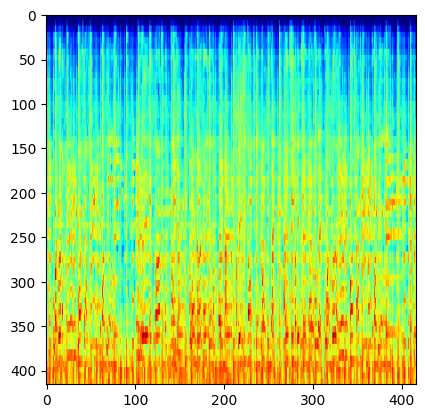

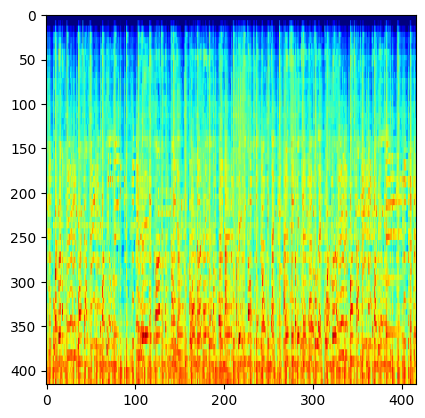

In [8]:
"""
Test cell to verify the correctness of the mel spectrogram image conversion and HDF5 saving process.

This cell:
- Loads a sample mel spectrogram image from disk and displays it.
- Displays the first image loaded from the HDF5 dataset (X[0]).
- Allows visual comparison to ensure the image preprocessing and saving steps are functioning as expected.
"""

ftmp = output_directory + '/blues.00000.png'
img = cv2.imread(ftmp)  # Read image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print(img)
plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
plt.imshow(X[0])
plt.show()